In [34]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split

In [35]:
df = pd.read_csv("Brownlow Full Database.csv")

def calculate_margin(row):
    if(row['Team'] == row['Home_Team']):
        return row['Home_Score'] - row['Away_Score']
    else:
        return row['Away_Score'] - row['Home_Score']
    
df = df.iloc[:, :-4]
df['Winning_Margin'] = df.apply(lambda x: calculate_margin(x), axis=1)
df = df.iloc[:, 10:]


In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [39]:
X = df.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions', # values not recorded in 2012 data
    'Brownlow_Votes'
], axis=1).values

y = df['Brownlow_Votes'].fillna(0).values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
pred = gnb.predict(X_test)

Normalized confusion matrix
[[0.88638572 0.07279795 0.03206997 0.00874636]
 [0.20890411 0.28082192 0.28424658 0.2260274 ]
 [0.11824324 0.24662162 0.31418919 0.32094595]
 [0.04682274 0.14381271 0.2541806  0.55518395]]


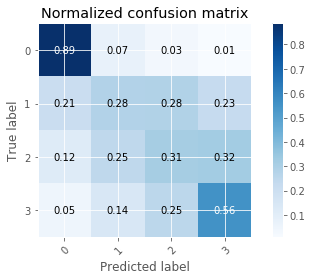

In [41]:
plot_confusion_matrix(y_test, pred, classes=['0','1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
df2019 = pd.read_csv("2019 Brownlow Match Data.csv")
df2019 = df2019.iloc[:, :-4]
df2019['Winning_Margin'] = df2019.apply(lambda x: calculate_margin(x), axis=1)
df2019 = df2019.iloc[:, 10:]
df2019.shape

X = df2019.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions' # values not recorded in 2012 data
], axis=1).values

In [43]:
probs = gnb.predict_proba(X)
hard_pred = gnb.predict(X)

In [44]:
df2019_predictions = pd.read_csv("2019 Brownlow Match Data.csv")
df2019_predictions['Predicted_Votes'] = hard_pred.tolist()

In [45]:
# Group by player and sort form high votes to low
results = pd.DataFrame(data = df2019_predictions.groupby(['Year','player_name','Team'])['Predicted_Votes'].sum())
results = results.reset_index()
results = results.sort_values('Predicted_Votes', ascending=False);

# Display the top 20 predicted vote getters for 2016
results.head(n=20)

,Year,player_name,Team,Predicted_Votes
9,2019,Adam Treloar,COLL,45.0
461,2019,Nat Fyfe,FRE,40.0
242,2019,Jack Macrae,WB,40.0
420,2019,Marcus Bontempelli,WB,39.0
382,2019,Lachie Neale,BL,39.0
81,2019,Brodie Grundy,COLL,37.0
622,2019,Travis Boak,PORT,37.0
494,2019,Patrick Dangerfield,GEEL,37.0
118,2019,Clayton Oliver,MELB,36.0
493,2019,Patrick Cripps,CARL,35.0


In [46]:
df2019_predictions['prediction0'] = probs[:,0] # Probably not needed
df2019_predictions['prediction1'] = probs[:,1]
df2019_predictions['prediction2'] = probs[:,2]
df2019_predictions['prediction3'] = probs[:,3]

In [48]:
df2019_predictions.to_csv('2019GaussianNaiveBayes.csv')